# Multimodal Clustering Analysis

Sep 2019  
Dongmin Kim
[underkoo@kaist.ac.kr](mailto:underkoo@kaist.ac.kr)

**Expected input data:**
Process 900 dim latent feature of multi-modal instagram posts

**What this script does:**  
Explorative data analysis on the mult-modal latent. Checks for feature correlation (features = 900 dimesnsions), applies and visualized PCA, applies t-SNE on different data (raw, PCA, etc).


In [57]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
import os
import seaborn as sns; sns.set()
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import Birch, SpectralClustering, AffinityPropagation, AgglomerativeClustering, MiniBatchKMeans, KMeans, DBSCAN, OPTICS
import matplotlib.colors as colors
import math
import time
import config

In [2]:
# magic line to have in-notebook interactive plots
%matplotlib notebook

In [3]:
#If you want to use a korean words, unblock it!
# path_gothic = './fonts/NanumBarunGothic.ttf'
# fontprop1 = fm.FontProperties(fname=path_gothic, size=3)

In [4]:
CONFIG = config.Config

## load latent feature

In [5]:
# load raw data
target_dataset = 'instagram0830'
df_data = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'normalized_' + target_dataset + '.csv'), index_col=0, header=None, encoding='utf-8-sig')
df_data.index.name = 'short_code'
#data_all = pd.read_csv('data/2019_05_01_naver_word2vec/word2vecBLOG)_1000.csv.zip', index_col=0, header=None)
print('complete csv shape: ' + str(df_data.shape))
print(df_data.iloc[:100])

complete csv shape: (97672, 900)
                  1         2         3         4         5         6    \
short_code                                                                
Bh9eo6zh3WM -0.064532 -0.065540 -0.209814 -0.021301  0.014854 -0.080327   
BoSvvEPhZMS -0.189088 -0.061798  0.148479 -0.113556  0.240953 -0.126832   
BgIh0ZjhI-d -0.113356 -0.203790 -0.030494  0.073606  0.054041  0.020635   
BhUIQpoF6gk  0.045795  0.004372 -0.166487 -0.096258 -0.052713  0.068679   
BnTl4IYg40P -0.100515 -0.241264  0.242434  0.161904 -0.174477  0.215176   
BoI9HCMhZQu -0.085147 -0.140315 -0.037167  0.080107  0.123270  0.045918   
BrKyWdQlwo8  0.008656 -0.124482 -0.047757  0.050220  0.043262 -0.016874   
BruQRNjn34Y  0.207228  0.329502  0.230217 -0.133004  0.149729 -0.068669   
Br2aY8rH2mA -0.254777 -0.200513 -0.068824  0.154603 -0.082460 -0.252173   
Bn_hS-NAq_Y  0.020322 -0.173628 -0.302585  0.020675  0.376006  0.308826   
Br69C_Qgk1T -0.307152  0.085923 -0.157152 -0.217041  0.257655 -0.03

In [6]:
print(df_data.describe())

                1             2             3             4             5    \
count  97672.000000  97672.000000  97672.000000  97672.000000  97672.000000   
mean      -0.003667     -0.050512     -0.038081      0.007919     -0.003272   
std        0.180865      0.183917      0.172385      0.169377      0.181788   
min       -1.046084     -1.121989     -1.039649     -1.109428     -1.324344   
25%       -0.105442     -0.162455     -0.138133     -0.079132     -0.107530   
50%       -0.009240     -0.071561     -0.044326      0.011126     -0.000036   
75%        0.098501      0.049385      0.055569      0.097889      0.097302   
max        1.071156      1.121295      1.102839      0.942443      0.955024   

                6             7             8             9             10   \
count  97672.000000  97672.000000  97672.000000  97672.000000  97672.000000   
mean       0.012683      0.025627     -0.033909      0.021694     -0.038649   
std        0.175488      0.164467      0.161267    

<IPython.core.display.Javascript object>


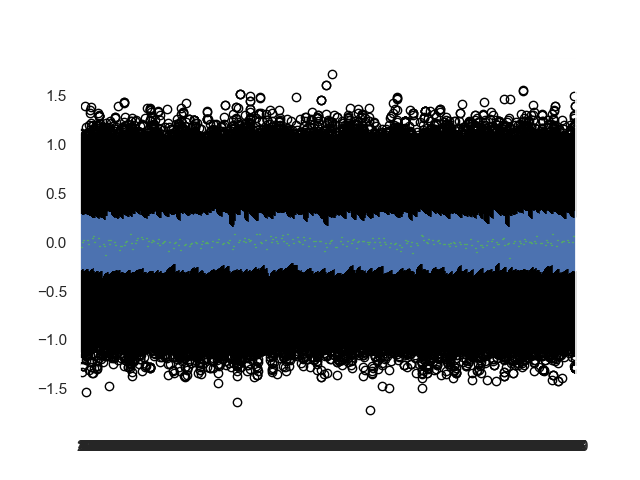

In [7]:
# data seems to be well normalized to mean or median = 0 and std = 1
plt.figure()
df_data.boxplot()

In [12]:
#df_normalized = df_data.div((np.sqrt(np.sum(np.square(df_data), axis=1))), axis=0)
#df_normalized.to_csv(os.path.join(CONFIG.CSV_PATH, 'normalized_' + target_dataset + '.csv'), header=None, encoding='utf-8-sig')

In [13]:
#print(df_normalized.describe())

                1             2             3             4             5    \
count  97672.000000  97672.000000  97672.000000  97672.000000  97672.000000   
mean      -0.001635     -0.015612     -0.009976      0.002386     -0.000558   
std        0.033311      0.036642      0.032356      0.029909      0.033636   
min       -0.124327     -0.145921     -0.129997     -0.130135     -0.149790   
25%       -0.024221     -0.041286     -0.032094     -0.017302     -0.023219   
50%       -0.002203     -0.015974     -0.010237      0.002772     -0.000008   
75%        0.020570      0.009393      0.011585      0.022450      0.021928   
max        0.147791      0.138709      0.130942      0.136195      0.138432   

                6             7             8             9             10   \
count  97672.000000  97672.000000  97672.000000  97672.000000  97672.000000   
mean       0.001563      0.006326     -0.010527      0.003784     -0.009799   
std        0.032235      0.029458      0.031519    

<IPython.core.display.Javascript object>


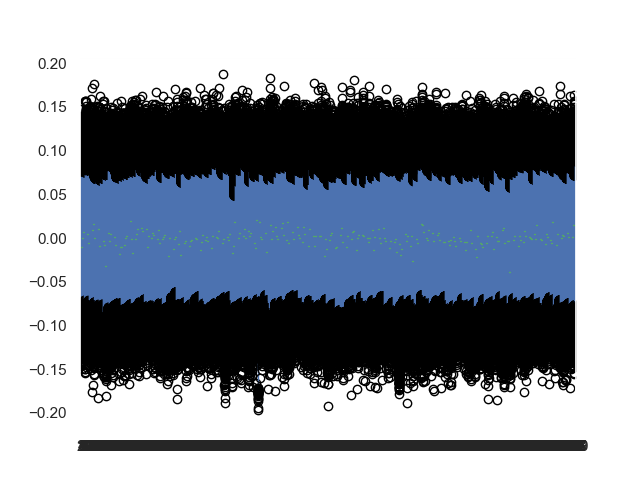

In [10]:
# data seems to be well normalized to mean or median = 0 and std = 1
#plt.figure()
#df_normalized.boxplot()

## PCA as dimensionality reduction

In [19]:
# PCA
pca = PCA(n_components=300)
df_pca_data = pd.DataFrame(pca.fit_transform(df_data))
df_pca_data.columns = ['PC' + str(i) for i in range(df_pca_data.shape[1])]
df_pca_data.index = df_data.index
print('singular_values_:\n' + str(pca.singular_values_))
print('components_:\n' + str(pca.components_))

# create PCA transformation DF
df_pca_transformation = pd.DataFrame(pca.components_).transpose()
df_pca_transformation.columns = ['PC' + str(i) for i in range(1, pca.n_components_ + 1)]
df_pca_transformation.index = df_data.columns
#print(df_pca_transformation)

singular_values_:
[196.07383149 166.90238638 162.30809343 146.24736992 135.70952724
 127.8272251  125.89100436 122.75696791 121.24361729 119.22722816
 117.02119734 116.5354251  115.73322915 113.91907    113.28700535
 112.20249566 112.06095194 111.20169202 110.78319696 110.23441726
 109.92950142 108.10947119 108.04137431 107.47397463 106.96049776
 106.34714979 105.81624462 105.26214877 104.96316167 104.55142249
 103.86329632 103.5448199  103.36864602 102.50072503 102.33369253
 102.03887524 101.74567694 101.56472061 101.18769065 100.86055498
 100.38920719 100.07988366  99.84320665  99.10197066  98.96690232
  98.59158562  98.31924923  98.00641639  97.63470049  97.4824423
  96.8930328   96.67166873  96.14583313  95.94795168  95.79863963
  95.58934406  95.4930082   95.3069676   95.14740462  94.946007
  94.59167969  94.32084967  93.68902464  93.47883679  93.43628285
  93.03475845  92.81944407  92.6887455   92.57564083  92.15985579
  92.05491336  91.80572155  91.58653611  91.45416824  91.0391

<IPython.core.display.Javascript object>


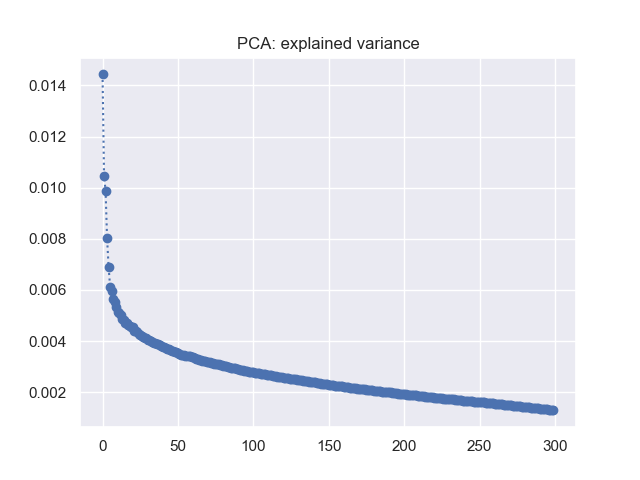

<IPython.core.display.Javascript object>


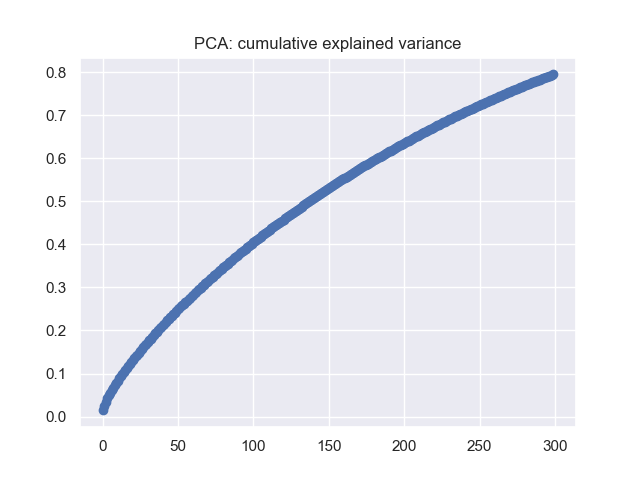

Text(0.5, 1.0, 'PCA: cumulative explained variance')

In [20]:
# PCA: plot variance explained
plt.figure()
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle=':')
plt.title('PCA: explained variance')

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle=':')
plt.title('PCA: cumulative explained variance')

In [21]:
def scatterplot_pointlabels(df_twocols, markersize=None):
    # basic scatterplot
    fig = plt.figure()
    plt.plot(df_twocols.iloc[:, 0], df_twocols.iloc[:, 1], marker='.', linestyle='None', markersize=markersize)

<IPython.core.display.Javascript object>


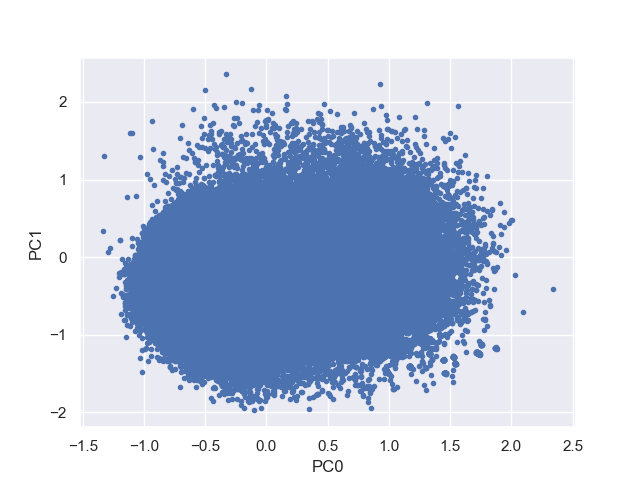

<IPython.core.display.Javascript object>


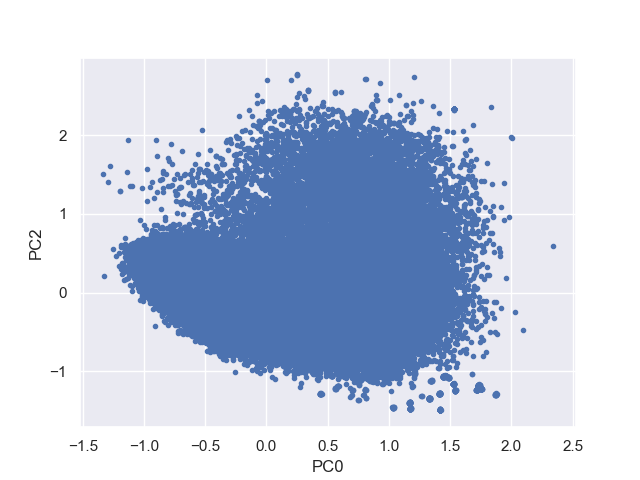

<IPython.core.display.Javascript object>


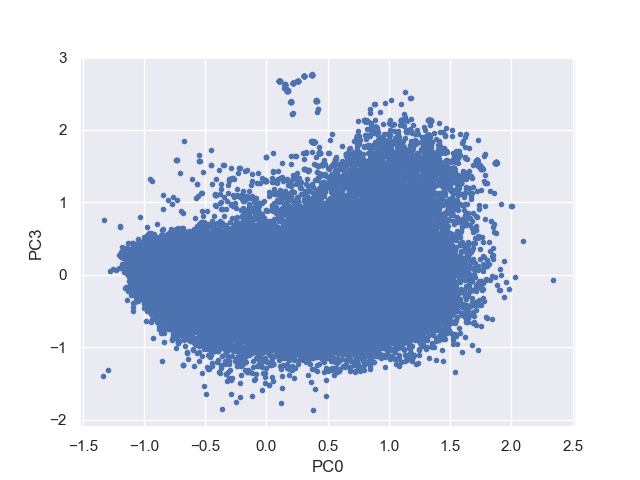

<IPython.core.display.Javascript object>


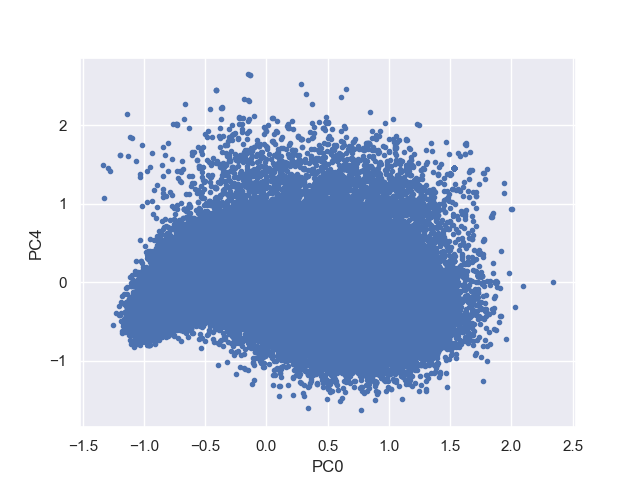

<IPython.core.display.Javascript object>


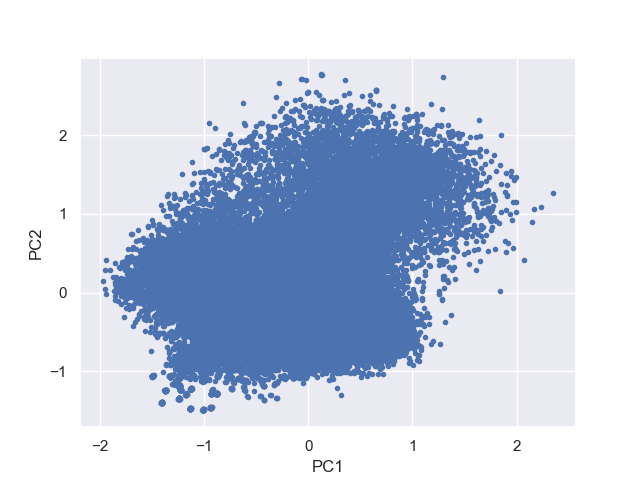

<IPython.core.display.Javascript object>


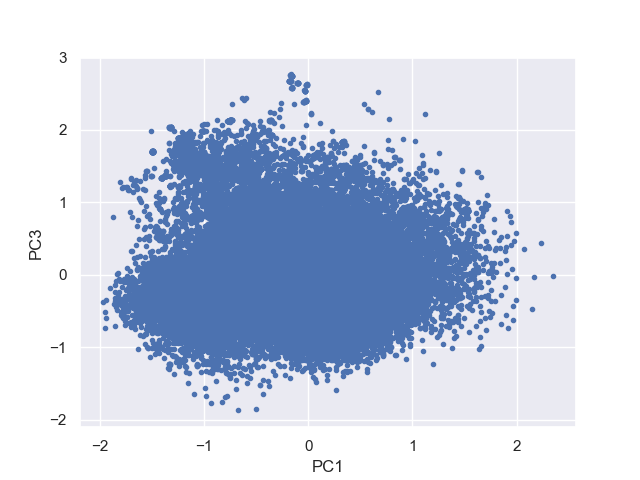

<IPython.core.display.Javascript object>


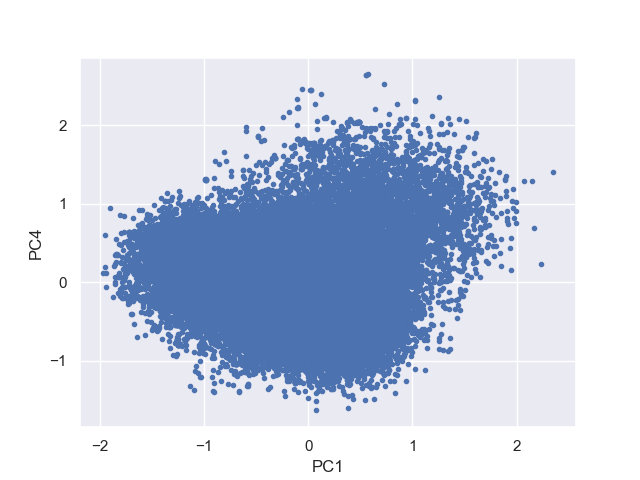

<IPython.core.display.Javascript object>


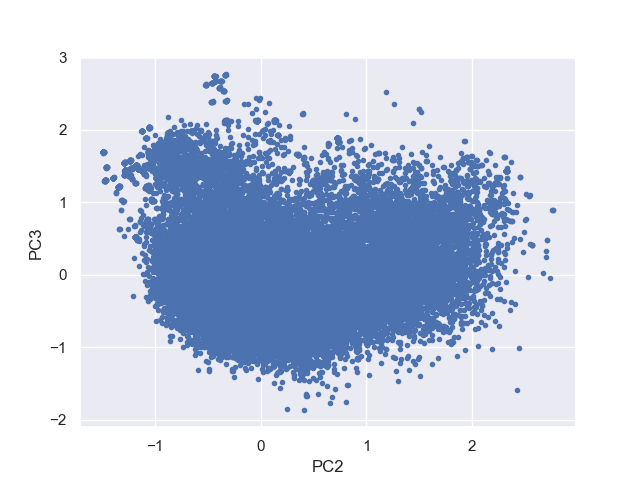

<IPython.core.display.Javascript object>


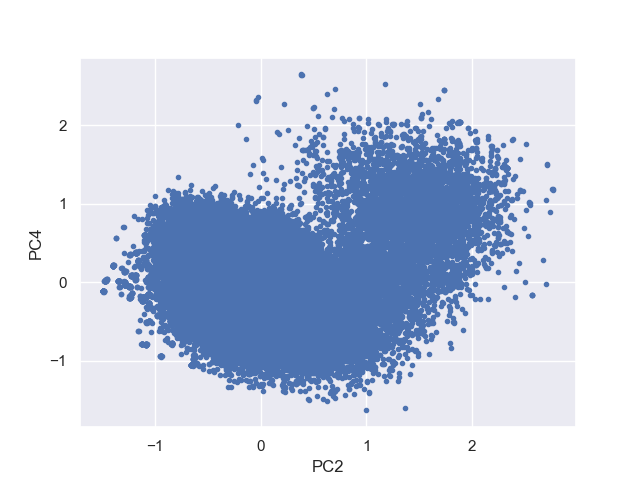

<IPython.core.display.Javascript object>


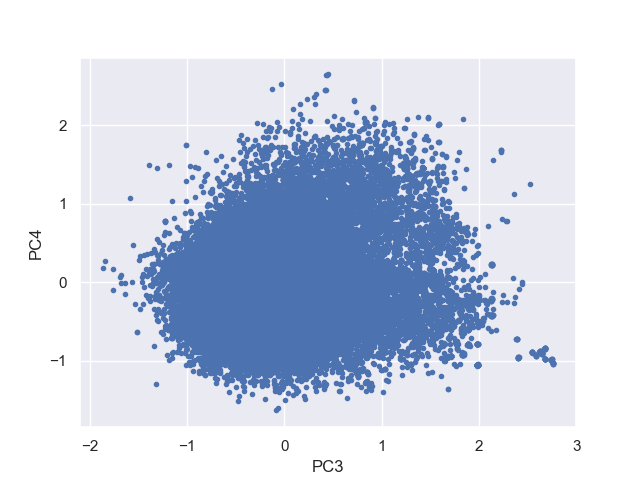

In [22]:
# plot PC dimensions
for dimen1 in range(0, 5):
    for dimen2 in range(dimen1 + 1, 5):
        # subset dataframe to the PC columns we need
        df_tmp = df_pca_data.iloc[:, [dimen1, dimen2]]
        
        # plot without labels
        scatterplot_pointlabels(df_tmp)
        # plt.title(df_tmp.columns)
        plt.xlabel(df_tmp.columns[0])
        plt.ylabel(df_tmp.columns[1])
        
        # plot with labels
        #scatterplot_pointlabels(df_tmp)
        # plt.title(df_tmp.columns)
        #plt.xlabel(df_tmp.columns[0])
        #plt.ylabel(df_tmp.columns[1])

In [23]:
df_pca_data.to_csv(os.path.join(CONFIG.CSV_PATH, 'pca_' + target_dataset + '.csv'), encoding='utf-8-sig')
#df_pca_data = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'pca_' + target_dataset + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
#df_pca_data.index.name = 'short_code'
print(df_pca_data.iloc[:100])

                  PC0       PC1       PC2       PC3       PC4       PC5  \
short_code                                                                
Bh9eo6zh3WM -0.547172  0.398855 -0.058295  0.341862 -0.293207 -0.093024   
BoSvvEPhZMS -0.012246 -0.109486 -0.309823 -0.164997  0.670187  0.144331   
BgIh0ZjhI-d -0.685261 -0.067102  0.329985  0.183837 -0.227403  0.396076   
BhUIQpoF6gk -0.629787  0.585411 -0.149979  0.223492 -0.115864 -0.117141   
BnTl4IYg40P  0.142944 -0.124586 -0.025383 -0.521687  0.697096 -0.308290   
BoI9HCMhZQu  0.316890  1.060196 -0.680123 -0.054551 -0.094246 -0.504667   
BrKyWdQlwo8 -0.445487  0.409775 -0.295738  0.093333 -0.042342 -0.065916   
BruQRNjn34Y  0.743539  0.424563 -0.014466 -0.384749 -0.415517 -0.049956   
Br2aY8rH2mA  0.146126  0.664748  1.675172  0.359781  0.292078  0.709454   
Bn_hS-NAq_Y -0.049060 -0.142177 -0.105897 -0.570757  0.120289 -0.744074   
Br69C_Qgk1T  0.518611  0.379986 -0.464472 -0.093562 -0.582378  0.542907   
BsFudrehNdL -0.592956 -0.

## Downsample

In [ ]:
def downsampling(df_data, num_samples=100):
#     idx = int(len(df_data)/num_samples)
#     idx_list = [x for x in range(0, len(df_data), idx)]
#     return df_data.iloc[idx_list]
    return df_data.sample(num_samples)

In [ ]:
ds_data = downsampling(df_data, 10000)

In [ ]:
print(ds_data)

## t-SNE

In [24]:
def do_tsne(tsne_object, data_to_pass):
    data_tsne = pd.DataFrame(tsne_object.fit_transform(data_to_pass))
    data_tsne.index = data_to_pass.index
    data_tsne.columns = [['tsne1', 'tsne2']]
    return data_tsne

In [ ]:
# on pca
# TODO tune the learning rate and the iterations (rest should be ok i guess)
start_time = time.time()
#tsne_pca = do_tsne(TSNE(n_components=2, perplexity=50, early_exaggeration=12.0, learning_rate=100, n_iter=5000, random_state=42, verbose=1), ds_pca_data)
ds_tsne_pca = do_tsne(MulticoreTSNE(n_components=2, perplexity=250, early_exaggeration=12.0, learning_rate=10, n_iter=1000, random_state=42, n_jobs=4, verbose=1), ds_pca_data)
print("time elapsed: " + str(time.time()-start_time))

In [ ]:
# plot t-SNE with PCA
scatterplot_pointlabels(ds_tsne_pca, 1)
plt.title('t-SNE on PCA data')
plt.savefig(os.path.join(CONFIG.SVG_PATH, 'ds_tsne_pca_' + target_dataset + '.svg'))

In [25]:
print(ds_tsne_pca.iloc[:100])
ds_tsne_pca.to_csv(os.path.join(CONFIG.CSV_PATH, 'ds_tsne_' + target_dataset + '.csv'), encoding='utf-8-sig')

NameError: name 'ds_tsne_pca' is not defined

In [26]:
# on pca
# TODO tune the learning rate and the iterations (rest should be ok i guess)
start_time = time.time()
#tsne_pca = do_tsne(TSNE(n_components=2, perplexity=50, early_exaggeration=12.0, learning_rate=100, n_iter=5000, random_state=42, verbose=1), df_pca_data)
tsne_pca = do_tsne(MulticoreTSNE(n_components=2, perplexity=500, learning_rate=10, n_iter=1000, random_state=42, n_jobs=4, verbose=1), df_pca_data)
print("time elapsed: " + str(time.time()-start_time))

time elapsed: 2836.0126569271088


<IPython.core.display.Javascript object>


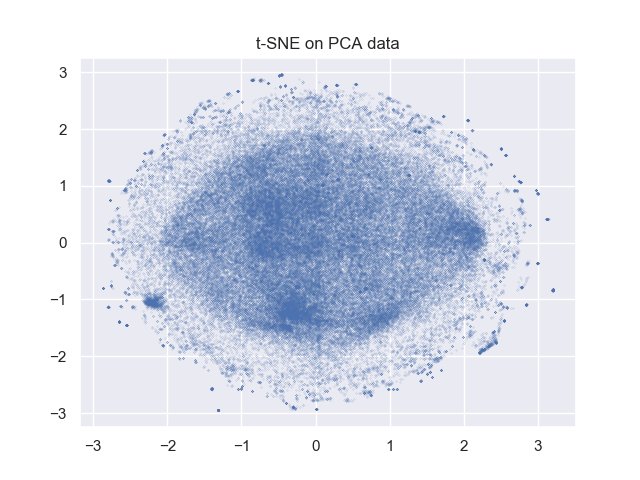

In [27]:
# plot t-SNE with PCA
scatterplot_pointlabels(tsne_pca, 0.2)
plt.title('t-SNE on PCA data')
plt.savefig(os.path.join(CONFIG.SVG_PATH, 'tsne_pca_' + target_dataset + '.svg'))


In [30]:
tsne_pca.to_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_' + target_dataset + '.csv'), encoding='utf-8-sig')
#tsne_pca = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_' + target_dataset + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
#tsne_pca = tsne_pca.iloc[1:]
#tsne_pca.index.name = 'short_code'
print(tsne_pca.iloc[:100])

                tsne1     tsne2
short_code                     
Bh9eo6zh3WM -0.460810  0.294711
BoSvvEPhZMS -0.318645  1.979027
BgIh0ZjhI-d  1.181634  0.115340
BhUIQpoF6gk -0.968664 -1.200871
BnTl4IYg40P -0.901584  0.737259
BoI9HCMhZQu -0.898039  1.432321
BrKyWdQlwo8 -0.195691 -1.365409
BruQRNjn34Y  0.244602  1.399499
Br2aY8rH2mA  0.119546  1.427601
Bn_hS-NAq_Y  0.448414 -1.521242
Br69C_Qgk1T -0.566340 -0.419409
BsFudrehNdL -0.598429 -1.209803
BlMgEb1AxuD -0.494893 -1.077209
BnTf4-wgGvu -0.338809 -1.281664
Bgx1HkjFoq_ -0.781186  0.636783
BhUnpHaDp-c -0.143888 -1.023534
BnyNSN0H5EM -0.603780 -0.049622
BoG5pQpHD92  0.499378  1.202751
BlK0wY_HAn8 -0.358824 -1.504700
Bnn9mSzFqrv -0.842822 -0.681284
BntC-EtF0mX -0.216549 -0.066913
BjPN_94AT_v  0.933068 -1.380955
BjSC2lEn7NH -0.071420  0.260925
BjjtqV6Aqic -0.503611  0.559144
BxZ20ODAh9u  1.039202 -0.210514
Bx8yyX2jgTC  0.897663  0.122515
Byxy79dhATV -0.535526 -0.051226
ByNtIv1jl5A -0.485205  0.151584
Bxc5LFOHGiI -0.833142  0.129946
BxM6YLfF

In [ ]:
# on raw data
# TODO tune the learning rate and the iterations (rest should be ok i guess)
# start_time = time.time()
# tsne_raw = do_tsne(MulticoreTSNE(n_components=2, perplexity=400, early_exaggeration=12.0, learning_rate=100, n_iter=10000, random_state=42, n_jobs=4), data)
# print("time elapsed: " + str(time.time()-start_time))

In [ ]:
# plot t-SNE with raw data
# scatterplot_pointlabels(tsne_raw, plot_labels=False)
# plt.title('t-SNE on raw data')
# scatterplot_pointlabels(tsne_raw)
# plt.title('t-SNE on raw data')

## Spectral Clustering

In [52]:
def clustering_score(X, max_num_clusters=10):
    sse = []
    sil = []
    for k in range(2, max_num_clusters + 1):
        start_time = time.time()
        temp_clustering = KMeans(n_clusters = k, random_state=42).fit(X)
        labels = temp_clustering.labels_
        sse.append(temp_clustering.inertia_)
        sil.append(silhouette_score(X, labels, metric = 'cosine'))
        print("time elapsed: " + str(time.time()-start_time))
    return sse, sil

In [48]:
def sse_distance(sse):
    distance = []
    last = len(sse) - 1
    for i in range(1, last):
        _distance = abs((sse[last] - sse[0]) * i - (last - 0) * sse[i] + last * sse[0] - sse[last] * 0) / math.sqrt(math.pow((sse[last] - sse[0]),2) + math.pow((last - 0),2))
        distance.append(_distance)
    return distance

time elapsed: 317.76719641685486
time elapsed: 343.00195574760437
time elapsed: 475.68772745132446
time elapsed: 449.6556293964386
time elapsed: 470.77417826652527
time elapsed: 493.21659779548645
time elapsed: 527.0838236808777
time elapsed: 518.4196538925171
time elapsed: 634.00053358078
time elapsed: 558.0883531570435
time elapsed: 551.5254218578339
time elapsed: 643.9246542453766
time elapsed: 599.8328404426575
time elapsed: 736.6387085914612
time elapsed: 536.8898077011108
time elapsed: 560.4886720180511
time elapsed: 564.593691110611
time elapsed: 539.0151147842407
time elapsed: 580.1993172168732
time elapsed: 614.3888716697693
time elapsed: 612.991637468338
time elapsed: 634.4751830101013
time elapsed: 681.5279686450958
time elapsed: 669.8460578918457
time elapsed: 658.779750585556
time elapsed: 739.9461262226105
time elapsed: 699.0489754676819
time elapsed: 777.4468896389008
time elapsed: 812.6264514923096


<IPython.core.display.Javascript object>


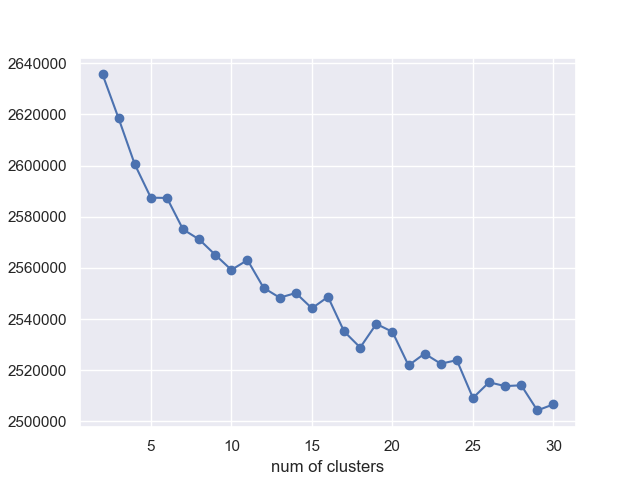

<IPython.core.display.Javascript object>


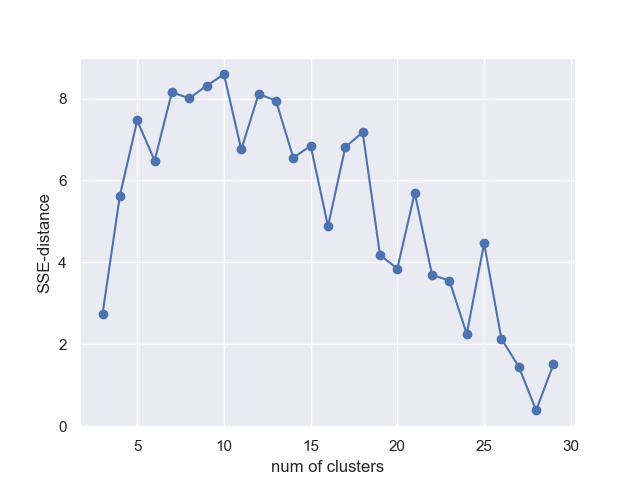

<IPython.core.display.Javascript object>


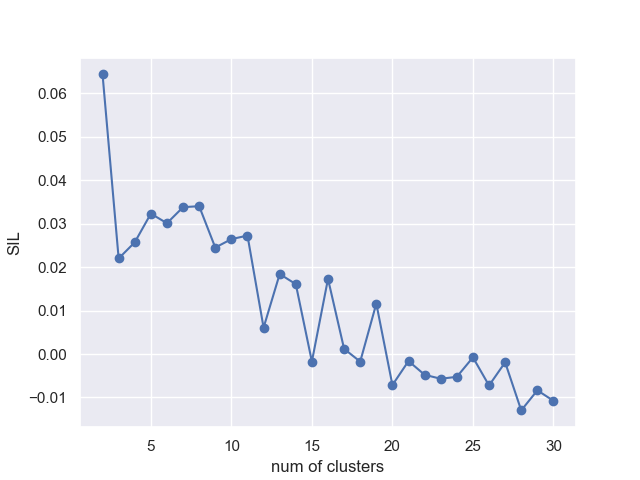

Text(0, 0.5, 'SIL')

In [53]:
max_num_clusters = 30
sse, sil = clustering_score(df_data, max_num_clusters)
fig = plt.figure()
plt.plot(range(2, max_num_clusters + 1), sse, marker='o')
plt.xlabel('num of clusters')
plt.ylabel('SSE')
distance = sse_distance(sse)
fig = plt.figure()
plt.plot(range(3, max_num_clusters), distance, marker='o')
plt.xlabel('num of clusters')
plt.ylabel('SSE-distance')
fig = plt.figure()
plt.plot(range(2, max_num_clusters + 1), sil, marker='o')
plt.xlabel('num of clusters')
plt.ylabel('SIL')

In [54]:
num_clusters = 11

In [55]:
#labeling points of tnse clusters
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=3, fontproperties=fontprop1)

In [ ]:
#Spectral clustering
#For using 'amg' you should install pyamg in you local computer.
# Check the component at
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
start_time = time.time()
#clustering = Birch(n_clusters=num_clusters).fit(tsne_pca)
#clustering = DBSCAN(eps=3, min_samples=5).fit(tsne_pca)
#clustering = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize", affinity= 'nearest_neighbors', n_neighbors=24, random_state=42, n_jobs=4).fit(df_pca_data)
#clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(data.loc[filtered_columns.index,:])# data, df_pca_data
clustering = KMeans(n_clusters=num_clusters).fit(df_data)# data, df_pca_data
print(clustering.labels_)
print("time elapsed: " + str(time.time()-start_time))
cluster_list = np.array(clustering.labels_).tolist()
tsne_pca['cluster'] = cluster_list
clustered_df = tsne_pca

In [ ]:
clustered_df = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'clustered_optics_tsne_' + target_dataset + '.csv'), index_col=0, header=None, encoding='utf-8-sig')
clustered_df = clustered_df.iloc[1:]
clustered_df.index.name = 'short_code'
print(clustered_df.iloc[:100])

In [60]:
def plot_spectral_clustering(dataframe, markersize=None):
    # plot spectrac clustering result
    # without label
    #scatterplot_pointlabels(dataframe[['x', 'y']], markersize)
    # better colors
    plt.figure(figsize=(13.2,9.6))
    #color_dict = {v: k for v, k in enumerate(sns.color_palette("Paired", num_clusters))}
    sns_plot = sns.scatterplot(x="x", y="y", hue='cluster_id', data=dataframe, marker='.', s=30)
    plt.savefig(os.path.join(CONFIG.SVG_PATH, 'spectralclustering_' + target_dataset + '.svg'))

            cluster
short_code         
Bh9eo6zh3WM       3
BoSvvEPhZMS       1
BgIh0ZjhI-d       3
BhUIQpoF6gk       8
BnTl4IYg40P       3
BoI9HCMhZQu       1
BrKyWdQlwo8       8
BruQRNjn34Y       1
Br2aY8rH2mA       1
Bn_hS-NAq_Y       2
Br69C_Qgk1T       3
BsFudrehNdL       8
BlMgEb1AxuD       8
BnTf4-wgGvu       8
Bgx1HkjFoq_       3
BhUnpHaDp-c       8
BnyNSN0H5EM       3
BoG5pQpHD92       1
BlK0wY_HAn8       8
Bnn9mSzFqrv       8
BntC-EtF0mX       3
BjPN_94AT_v       2
BjSC2lEn7NH       3
BjjtqV6Aqic       3
BxZ20ODAh9u       3
Bx8yyX2jgTC       3
Byxy79dhATV       3
ByNtIv1jl5A       3
Bxc5LFOHGiI       3
BxM6YLfFbfW       1
...             ...
BgncJtigf9t       5
BgprymNgrur       1
BgwPwdqnkqF       0
BimM3sDnsbI       1
Biyk5ylA3Ox       1
BoXv3t9AI-J       1
BoZWbEtAkJE       4
BodYl0IFhxI       3
ByjzO1XnS4M       3
B0XDEIhHZnx       8
Bw6tar9nqZx       8
BxEzVaVnMQ8       9
Bx1rf1LhPNT       3
BvDUmAUnGPQ       3
BvGPcGJA35r       2
Bw6kX6EH9Y3       0
BpBCTn_n3dc       2


<IPython.core.display.Javascript object>


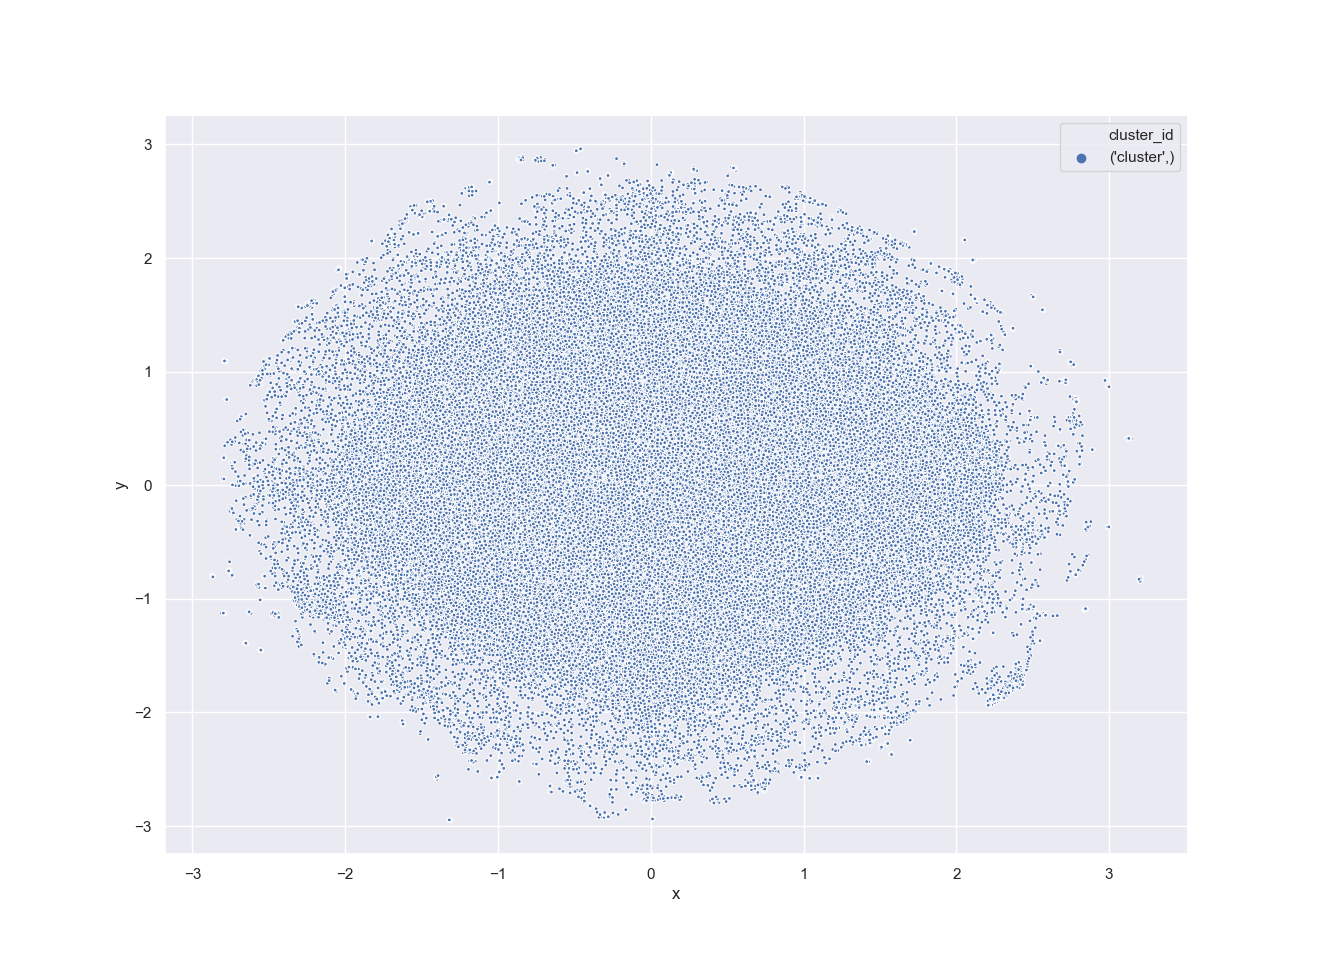

In [67]:
# put clustering info into df
df_clustered_spectral = pd.DataFrame({'x': clustered_df.tsne1.squeeze(), 
                                      'y': clustered_df.tsne2.squeeze(), 
                                      'word': clustered_df.index.tolist(), 
                                      'cluster_id': clustered_df.cluster})
# debug prints
print(clustered_df.cluster)
print(df_clustered_spectral)
print(df_clustered_spectral.dtypes)
plot_spectral_clustering(df_clustered_spectral, 0.2)       
#ds_clustered_spectral = downsampling(df_clustered_spectral, 5000)
#plot_spectral_clustering(ds_clustered_spectral, 0.2)       
# print(df_clustered_spectral.iloc[:10, :])
# df_clustered_spectral['cluster_id'].describe() # 30 integer clusters